# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [8]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [9]:
# Import essential libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

Load the dataset.

In [11]:
# Load and unzip the dataset
zip_path = 'C:\\Users\\Ankita\\Desktop\\upgrd\\convolutional neural networks\\data.zip'
extract_dir = 'C:\\Users\\Ankita\\Desktop\\upgrd\\convolutional neural networks'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset unzipped to:", extract_dir)


Dataset unzipped to: C:\Users\Ankita\Desktop\upgrd\convolutional neural networks


In [152]:
# checking version
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [18]:
# Create a function to load the raw images


def load_images_from_folder(folder_path, img_size=(128, 128)):
    images = []
    labels = []
    class_names = os.listdir(folder_path)
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [84]:
# Get the images and their labels

# path to extracted dataset directory
dataset_path = 'C:\\Users\\Ankita\\Desktop\\upgrd\\convolutional neural networks\\data'

image_size = (128, 128)

# Load the images and labels
images, labels = load_images_from_folder(dataset_path, img_size=image_size)

print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape}")
print(f"Unique labels: {set(labels)}")


Loaded 7625 images.
Image shape: (128, 128, 3)
Unique labels: {np.str_('Food_Waste'), np.str_('Paper'), np.str_('Cardboard'), np.str_('Metal'), np.str_('Other'), np.str_('Plastic'), np.str_('Glass')}


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

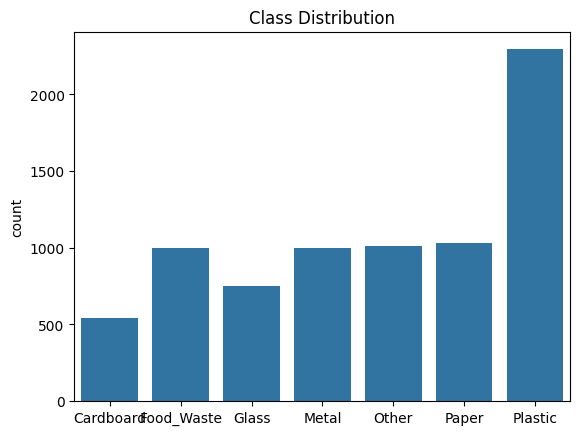

In [86]:

# Bar Plot distribution

sns.countplot(x=labels)
plt.title("Class Distribution")
plt.show()




#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [127]:
# Visualise Sample Images (across different labels)

def plot_sample_images(images, labels):
    plt.figure(figsize=(10, 10))
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 6))

    for idx, label in enumerate(unique_labels):
        # Get the first image that belongs to this class
        index = np.where(labels == label)[0][0]
        plt.subplot(1, len(unique_labels), idx + 1)
        plt.imshow(images[index])
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



# plot the first few images
plot_sample_images(images, labels)



<Figure size 1000x1000 with 0 Axes>

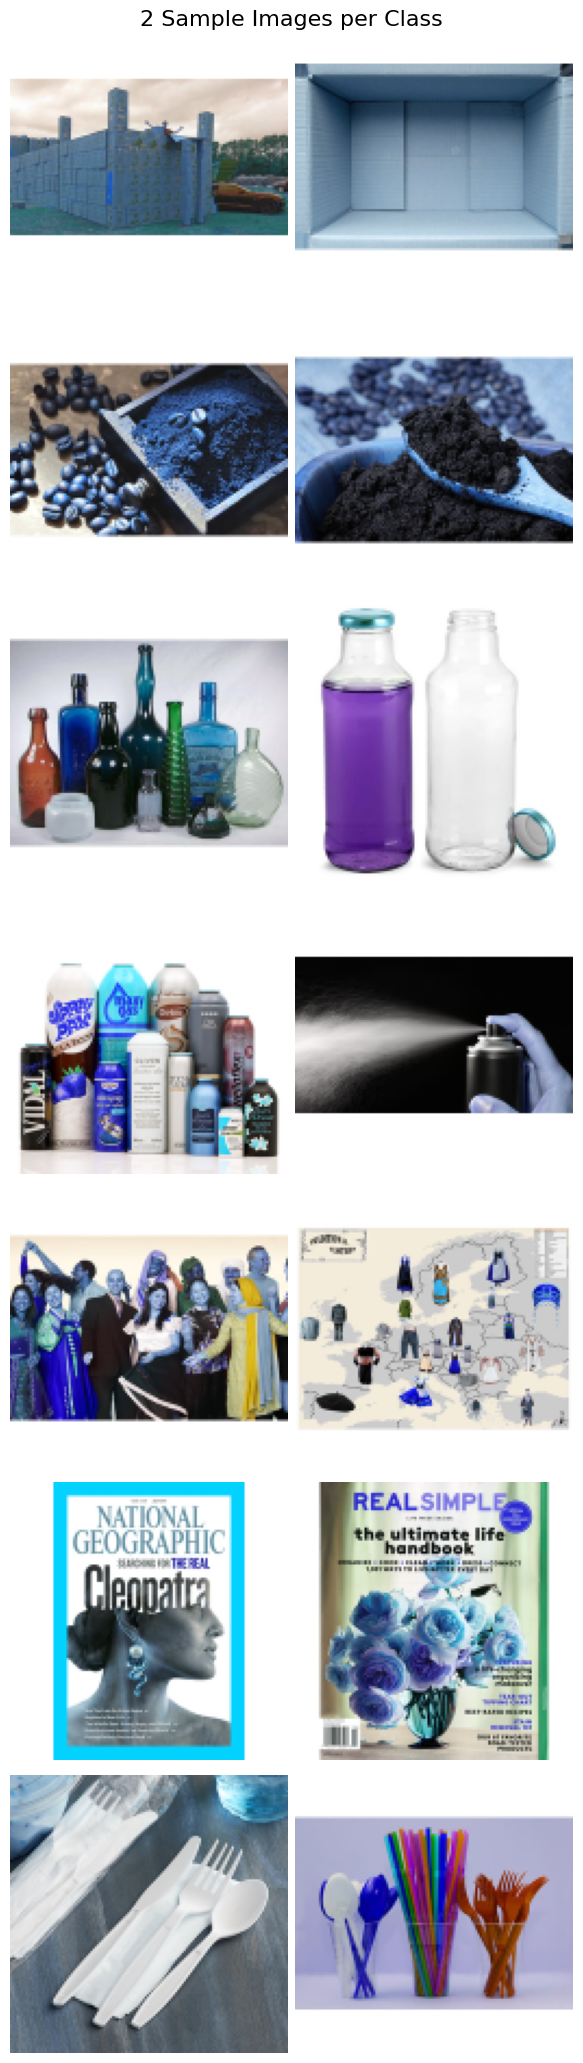

In [134]:
def plot_multiple_images_per_class(images, labels, n=3):
    """
    Plots multiple images (e.g., 3) per class from the dataset.
    """
    unique_labels = np.unique(labels)
    total_classes = len(unique_labels)
    plt.figure(figsize=(n * 3, total_classes * 3))

    for row_idx, label in enumerate(unique_labels):
        # Get the indices of the first n images for this class
        class_indices = np.where(labels == label)[0][:n]

        for col_idx, img_idx in enumerate(class_indices):
            plot_index = row_idx * n + col_idx + 1
            plt.subplot(total_classes, n, plot_index)
            plt.imshow(images[img_idx])
            if col_idx == 0:
                plt.ylabel(label, fontsize=12)
            plt.axis('off')

    plt.suptitle(f'{n} Sample Images per Class', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_multiple_images_per_class(images, labels, n=2)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [136]:
# Resize the image dimensions
def get_image_dimensions(folder_path):
    widths, heights = [], []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                h, w, _ = img.shape
                heights.append(h)
                widths.append(w)
    return min(widths), max(widths), min(heights), max(heights)

min_w, max_w, min_h, max_h = get_image_dimensions(dataset_path)

print(f"Width: Min = {min_w}, Max = {max_w}")
print(f"Height: Min = {min_h}, Max = {max_h}")



Width: Min = 256, Max = 256
Height: Min = 256, Max = 256


In [138]:
def get_median_image_dimensions(folder_path):
    widths, heights = [], []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                h, w = img.shape[:2]
                widths.append(w)
                heights.append(h)
    median_w = int(np.median(widths))
    median_h = int(np.median(heights))
    return (median_w, median_h)
median_size = get_median_image_dimensions(dataset_path)
print(f"Median image size: {median_size}")

Median image size: (256, 256)


In [ ]:
### hence we are using constant valu 128 X 128

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [142]:
# Encode the labels suitably

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [146]:
# Assign specified parts of the dataset to train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(images, one_hot_labels, test_size=0.3, stratify=one_hot_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

In [148]:
# Build and compile the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)



C:\Users\Ankita\tf_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.2485 - loss: 109.9372 - val_accuracy: 0.3112 - val_loss: 1.8717
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 38s 225ms/step - accuracy: 0.3263 - loss: 1.8098 - val_accuracy: 0.3523 - val_loss: 1.7539
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 38s 230ms/step - accuracy: 0.3779 - loss: 1.6514 - val_accuracy: 0.3916 - val_loss: 1.6804
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 38s 227ms/step - accuracy: 0.4266 - loss: 1.5072 - val_accuracy: 0.4327 - val_loss: 1.6292
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 38s 226ms/step - accuracy: 0.5233 - loss: 1.2944 - val_accuracy: 0.4423 - val_loss: 1.6467
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 38s 229ms/step - accuracy: 0.5741 - loss: 1.1575 - val_accuracy: 0.4441 - val_loss: 1.6294
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 37s 223ms/step - accuracy: 0.6316 - loss: 0.9967 - val_accuracy: 0.4615 - val_loss: 1.6107
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 37s 220ms/step - accuracy: 0.6681 - loss:

Use appropriate metrics and callbacks as needed.

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [150]:
# Evaluate on the test set; display suitable metrics
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4588 - loss: 2.0588
Test Accuracy: 46.42%


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [52]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [55]:
# Create a function to augment the images




In [56]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [58]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

In [ ]:
* A straightforward convolutional neural network demonstrated effective performance in classifying waste across seven categories.
* This methodology holds potential for integration into automated waste management systems, such as smart bins or industrial recycling units.
* Further enhancements are achievable through the adoption of deeper neural architectures, transfer learning using models like MobileNetV2, 
  and the inclusion of larger datasets.

